In [9]:
import re
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import KernelPCA, PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, SVMSMOTE

from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import KFold, RandomizedSearchCV,GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, make_scorer, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [10]:
# Declare variables
base_path_normal_train = 'Saved_Embeddings/Normal/'
base_path_abnormal_train = 'Saved_Embeddings/Abnormal/'
base_path_normal_test = 'Saved_Embeddings/Normal_test/'
base_path_abnormal_test = 'Saved_Embeddings/Abnormal_test/'
use_dimensionality_reduction = True
use_scaler = True
use_age_gender_data = False
use_oversampling = True

In [11]:
#Data Loading and scaling

def load_all_image_embeddings(base_path_normal, base_path_abnormal, age_gender_data):
    embeddings = []
    labels = []
    age_list = []
    gender_list = []
    normal_age_gender_data = age_gender_data[0]
    abnormal_age_gender_data = age_gender_data[1]
    normal_id_list = list(normal_age_gender_data['ID'])
    abnormal_id_list = list(abnormal_age_gender_data['ID'])
    for k in os.listdir(base_path_normal):
        age, gender = None, None
        id_cleaned = int(''.join(filter(str.isdigit, k)))
        if id_cleaned in normal_id_list:
            _, gender, age = list(normal_age_gender_data.loc[normal_age_gender_data['ID'] == id_cleaned].values.ravel())
        embeddings.append(np.load(base_path_normal + k))
        age_list.append(age)
        gender_list.append(gender)
        labels.append(0)
    for s in os.listdir(base_path_abnormal):
        age, gender = None, None
        id_cleaned = int(''.join(filter(str.isdigit, s)))
        if id_cleaned in abnormal_id_list:
            _, gender, age = list(
                abnormal_age_gender_data.loc[abnormal_age_gender_data['ID'] == id_cleaned].values.ravel())
        embeddings.append(np.load(base_path_abnormal + s))
        labels.append(1)
        age_list.append(age)
        gender_list.append(gender)
    return np.vstack(embeddings), np.array(labels), age_list, gender_list


def load_all_data():
    normal_train, abnormal_train, normal_test, abnormal_test = add_age_gender_data()

    X_train, labels_train, age_list_train, gender_list_train = load_all_image_embeddings(base_path_normal_train,
                                                                                         base_path_abnormal_train,
                                                                                         (normal_train, abnormal_train))
    X_test, labels_test, age_list_test, gender_list_test = load_all_image_embeddings(base_path_normal_test,
                                                                                     base_path_abnormal_test,
                                                                                     (normal_test, abnormal_test))
    #return X_train, labels_train, X_test, labels_test, age_list_train, age_list_test, gender_list_train, gender_list_test
    return X_train, labels_train, X_test, labels_test

def add_age_gender_data():
    normal_train = pd.read_excel('age and gender.xlsx', sheet_name=0)
    abnormal_train = pd.read_excel('age and gender.xlsx', sheet_name=1)
    normal_test = pd.read_excel('age and gender.xlsx', sheet_name=2)
    abnormal_test = pd.read_excel('age and gender.xlsx', sheet_name=3)
    return normal_train, abnormal_train, normal_test, abnormal_test


def add_age_gender_to_data(data, agedata, gender_data):
    temp_array = []
    for index, k in enumerate(data):
        temp_k = list(k) + [agedata[index], gender_data[index]]
        temp_array.append(temp_k)
    return np.array(temp_array)


def do_scaling(X_train, X_test, method='standard'):
    if method == 'standard':
        scaler = StandardScaler()
        scaler.fit(X_train)
        print("Scaler used :- ", str("Standard Scaler"))
        return scaler.transform(X_train), scaler.transform(X_test)
    elif method == 'minmax':
        scaler = MinMaxScaler()
        scaler.fit(X_train)
        print("Scaler used :- ", str("MinMax Scaler"))
        return scaler.transform(X_train), scaler.transform(X_test)
    else:
        return 'Not a valid method'



In [12]:
# Confusion Matrix
def cm_display(arr1, arr2, title):
    
    # imb_svm_df
    cm = confusion_matrix(  arr1, arr2)
    plt.figure(figsize = (5,5))
    ConfusionMatrixDisplay(cm).plot(cmap = 'viridis')
    plt.title = title

In [13]:
# Oversampling

def use_oversampling_method(X_train, Y_train, method='adasyn'):
    if method == 'smote':
        oversample = SMOTE()
        X_train, Y_train = oversample.fit_resample(X_train, Y_train)
        print("oversampling used :- ", str(method))
        return X_train, Y_train
    elif method == 'randomsampler': #vulnerable to overfitting
        random = RandomOverSampler()
        X_train, Y_train = random.fit_resample(X_train, Y_train)
        print("oversampling used :- ", str(method))
        return X_train, Y_train
    elif method == 'adasyn':
        adasyn = ADASYN()
        X_train, Y_train = adasyn.fit_resample(X_train, Y_train)
        print("oversampling used :- ", str(method))
        return X_train, Y_train
    elif method == "svmsmote":
        svmsmote = SVMSMOTE()
        X_train, Y_train = svmsmote.fit_resample(X_train, Y_train)
        print("oversampling used :- ", str(method))
        return X_train, Y_train
    else:
        print('Wrong Method')


In [14]:
def tsne_reduction(X_train, X_test, Y_train, Y_test, rand):
    earlier_dimension = X_train.shape[1]
    X = np.concatenate([X_train, X_test], axis=0)
    Y = np.concatenate([Y_train, Y_test], axis=0)
    X_embedded = TSNE(n_components=3, init = 'random', random_state = rand).fit_transform(X) #random_state = 42, n_components=3
    X_train, X_test, Y_train, Y_test = train_test_split(X_embedded, Y, test_size=.1)
#     print("Dimension Reduced from :- ", str(earlier_dimension), " to :- ", str(X_train.shape[1]), " Using TSNE "
    return X_train, X_test, Y_train, Y_test

In [15]:
# Models


def calculate_all_acc_parameters(predicted_labels, y_true):
    return accuracy_score(y_true, predicted_labels), f1_score(y_true, predicted_labels), \
recall_score(y_true, predicted_labels), \
precision_score(y_true, predicted_labels)


def svm_model(X_train, Y_train, X_test, Y_test, params, rand ):
    print(f'===================== Running the SVM model  with {params}')
#     svm_classifier = SVC(kernel=params['kernel'], gamma = params['gamma'], C = params['C'])
    svm_classifier = SVC().set_params(**params)
    svm_classifier.fit(X_train, Y_train)
    pred_labels_test= svm_classifier.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(Y_test, pred_labels_test).ravel()
    precision = tp / (tp + fp) #should be fp instead of tn
    recall = tp / (tp + fn)
    
    if (precision > 0 ) and (recall > 0):
        
        f1 = 2 * precision * recall / (precision + recall)
        print('----------------', f1, recall, precision, sep = '\t')
    else:
        print('----',  precision, recall, sep = '\t')

    accuracy, f1score, recall, precision=calculate_all_acc_parameters(pred_labels_test, Y_test)
#     print(accuracy,f1score,recall,precision)
    plt_title = f'Random State = {rand}'
    cm_display(Y_test, pred_labels_test, plt_title)
    
    return (Y_test, pred_labels_test), f1score




Data size.................................
(982, 2048)
(100, 2048)
...............................................
oversampling used :-  randomsampler
Data size after oversampling ..................
(1794, 2048)
(100, 2048)
...............................................
Scaler used :-  MinMax Scaler


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(



100. Data size after TSNE: .........................
(1704, 3) (190, 3)
...............................................
===================== Running the SVM model  with {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
----------------	0.9435897435897437	0.989247311827957	0.9019607843137255


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(



101. Data size after TSNE: .........................
(1704, 3) (190, 3)
...............................................
===================== Running the SVM model  with {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
----------------	0.9197860962566845	0.9885057471264368	0.86


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(



102. Data size after TSNE: .........................
(1704, 3) (190, 3)
...............................................
===================== Running the SVM model  with {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
----------------	0.8720379146919433	0.968421052631579	0.7931034482758621


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(



103. Data size after TSNE: .........................
(1704, 3) (190, 3)
...............................................
===================== Running the SVM model  with {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
----------------	0.84375	0.8804347826086957	0.81


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(



104. Data size after TSNE: .........................
(1704, 3) (190, 3)
...............................................
===================== Running the SVM model  with {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
----------------	0.8431372549019609	0.9148936170212766	0.7818181818181819


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(



105. Data size after TSNE: .........................
(1704, 3) (190, 3)
...............................................
===================== Running the SVM model  with {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
----------------	0.7922705314009661	0.9111111111111111	0.7008547008547008


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(



106. Data size after TSNE: .........................
(1704, 3) (190, 3)
...............................................
===================== Running the SVM model  with {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
----------------	0.8512820512820514	0.8556701030927835	0.8469387755102041


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(



107. Data size after TSNE: .........................
(1704, 3) (190, 3)
...............................................
===================== Running the SVM model  with {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
----------------	0.806122448979592	0.8229166666666666	0.79


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(



108. Data size after TSNE: .........................
(1704, 3) (190, 3)
...............................................
===================== Running the SVM model  with {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
----------------	0.8121827411167514	0.8695652173913043	0.7619047619047619


C:\Users\DELL\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(



109. Data size after TSNE: .........................
(1704, 3) (190, 3)
...............................................
===================== Running the SVM model  with {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
----------------	0.7843137254901962	0.8602150537634409	0.7207207207207207


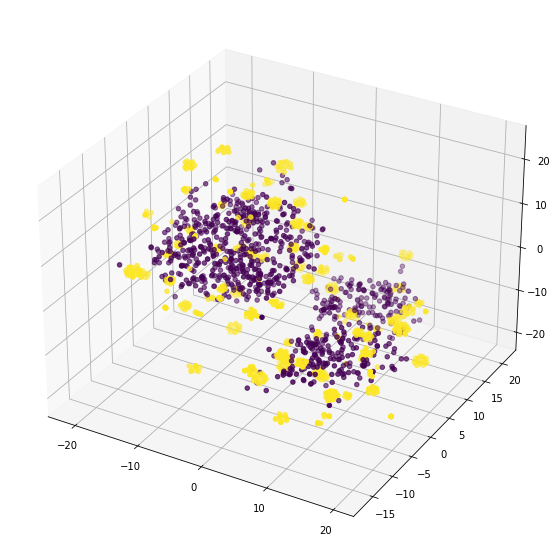

<Figure size 360x360 with 0 Axes>

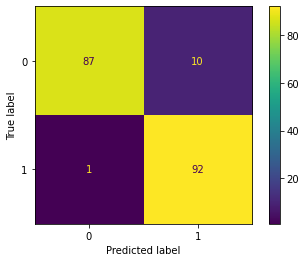

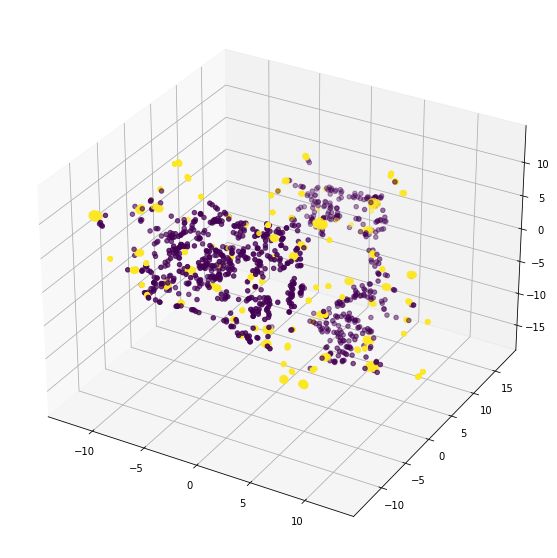

<Figure size 360x360 with 0 Axes>

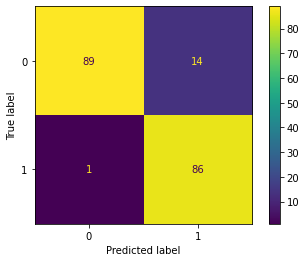

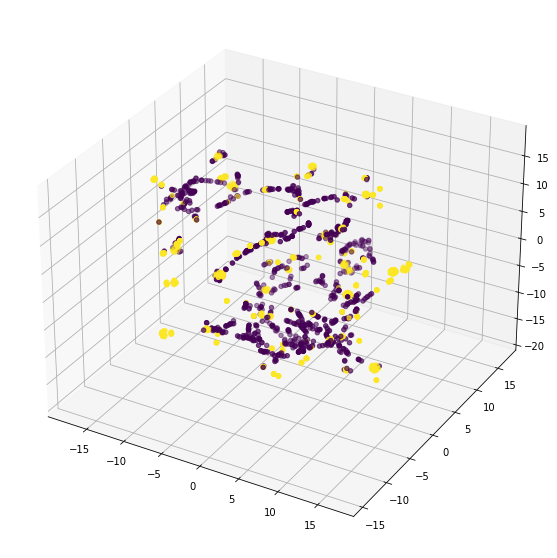

<Figure size 360x360 with 0 Axes>

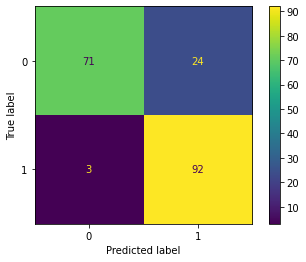

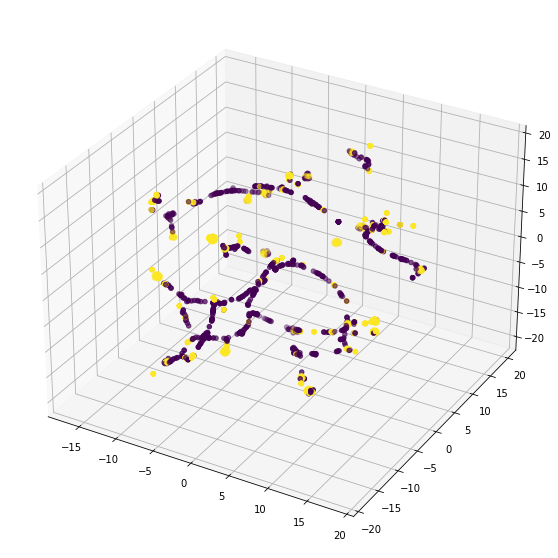

<Figure size 360x360 with 0 Axes>

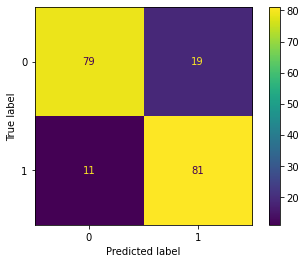

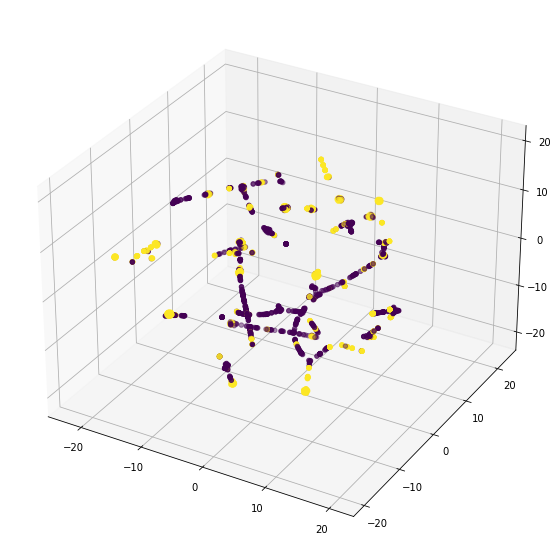

<Figure size 360x360 with 0 Axes>

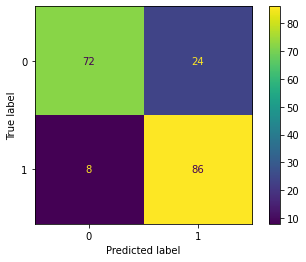

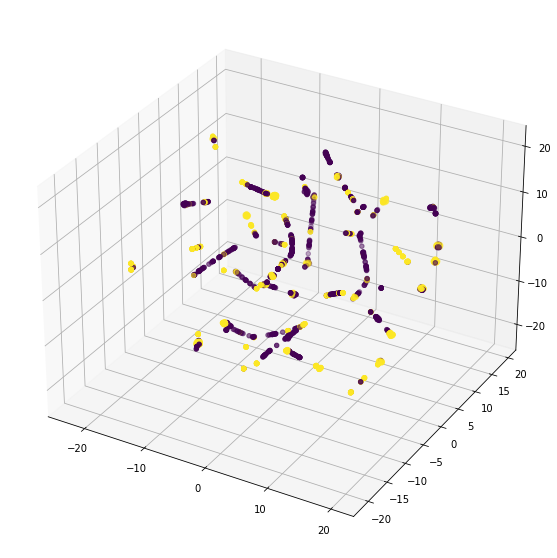

<Figure size 360x360 with 0 Axes>

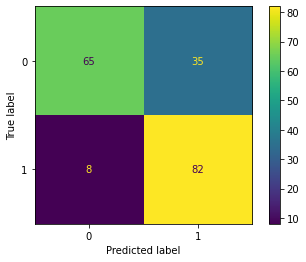

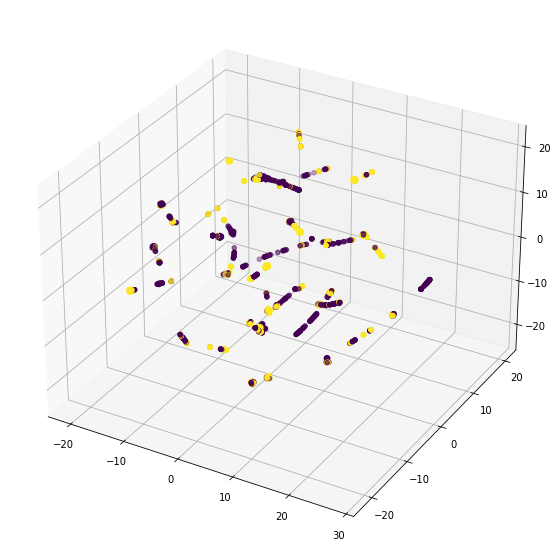

<Figure size 360x360 with 0 Axes>

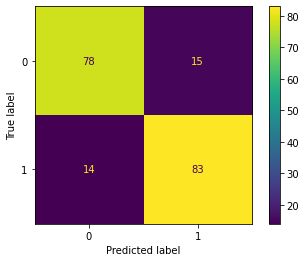

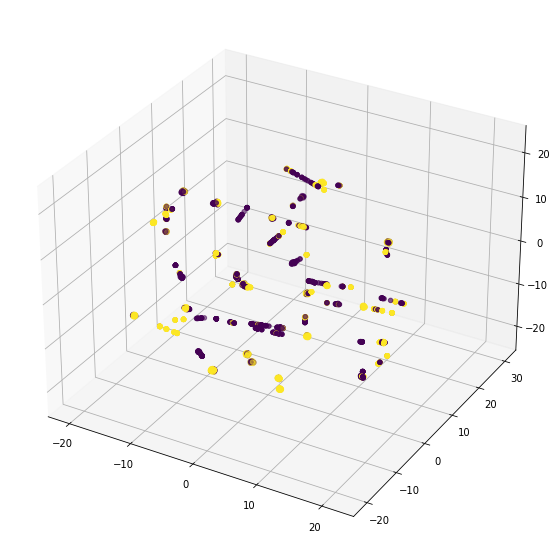

<Figure size 360x360 with 0 Axes>

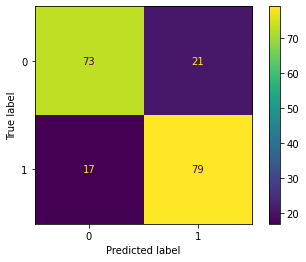

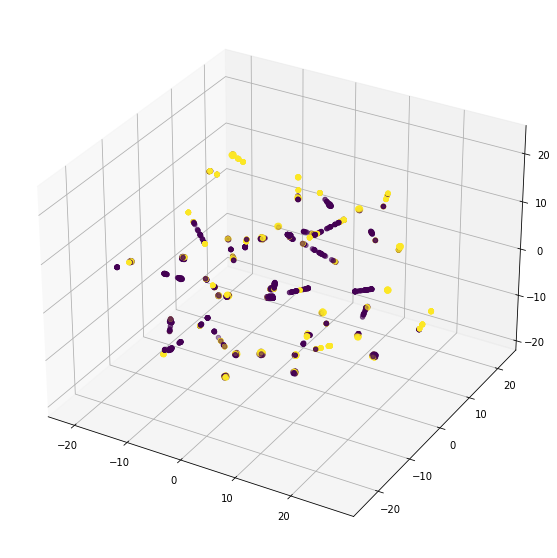

<Figure size 360x360 with 0 Axes>

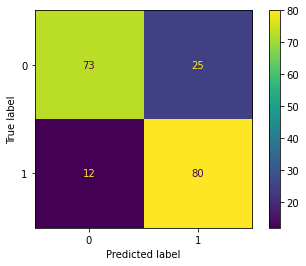

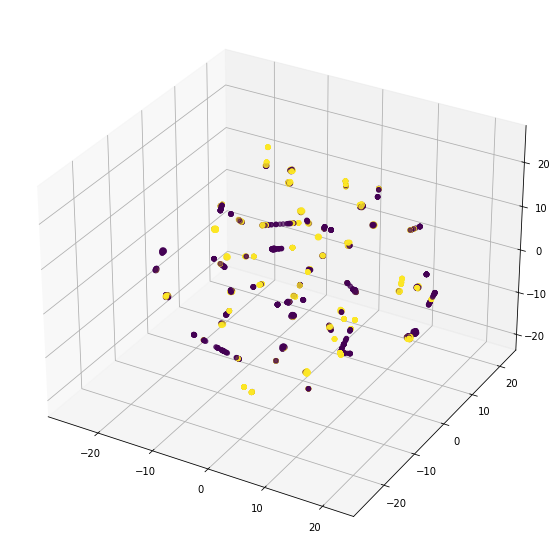

<Figure size 360x360 with 0 Axes>

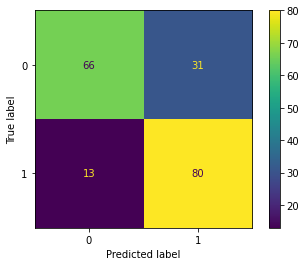

In [16]:

X_train, Y_train, X_test, Y_test = load_all_data()
# X_train, Y_train, X_test, Y_test, age_list_train, age_list_test, gender_list_train, gender_list_test = load_all_data()

print('Data size.................................')
print(X_train.shape)
print(X_test.shape)
print('...............................................')



'''
oversampling was here. Which should go first, oversampling or dimensionality reduction?
'''
if use_oversampling:
    X_train, Y_train = use_oversampling_method(X_train, Y_train, method='randomsampler')

print('Data size after oversampling ..................')
print(X_train.shape)
print(X_test.shape)
print('...............................................')


if use_scaler:
    X_train, X_test = do_scaling(X_train, X_test, method = 'minmax')

# best_ps={'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

best_ps={'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

performance = []
for i in range(100, 110):
    X_train, X_test, Y_train, Y_test = tsne_reduction(X_train, X_test, Y_train, Y_test, i)
    print(f'\n{i}. Data size after TSNE: .........................')
    print(X_train.shape, X_test.shape)
    print('...............................................')
    df_train = pd.DataFrame(X_train)
    df_train.columns = ['x', 'y', 'z']
    df_train['status'] = Y_train
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection = '3d')

    x = df_train.x
    y = df_train.y
    z = df_train.z

    ax.scatter(x,y,z, zdir = 'z',c = df_train.status, cmap = 'viridis')
    result,f1score =svm_model(X_train, Y_train, X_test, Y_test, best_ps, i)
    performance.append([i,f1score])
    pd.DataFrame(result).to_csv(f'testing\Testing_Rand_State_{i}.csv', index=False)




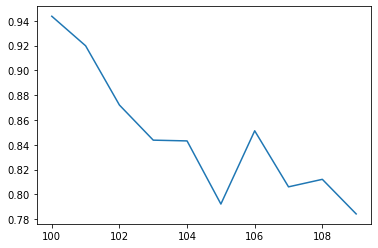

In [17]:
performance_df = pd.DataFrame(performance)
performance_df.columns = ['Random_state', 'F1Score']
plt.figure()
plt.plot(performance_df.Random_state, performance_df.F1Score)